# **Advanced DNN with Callbacks and Adaptive Learning Rate**

*Objective: Develop an advanced DNN with sophisticated features such as callbacks and adaptive learning rates for enhanced performance and stability*

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Embedding, LSTM, GRU, Dense, Bidirectional, Input, Attention, Layer)
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


2024-10-02 13:37:11.416954: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 13:37:12.229187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## **Load Dataset and Data Preprocessing**

In [2]:
# Load the IMDB dataset
vocab_size = 20000  
max_sequence_length = 200  

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_test)}")

# Pad the sequences
x_train_padded = pad_sequences(x_train, maxlen=max_sequence_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test, maxlen=max_sequence_length, padding='post', truncating='post')

print(f"Padded training shape: {x_train_padded.shape}")
print(f"Padded testing shape: {x_test_padded.shape}")


Training samples: 25000
Testing samples: 25000
Padded training shape: (25000, 200)
Padded testing shape: (25000, 200)


In [3]:
# Build the base model
# we're including embedded, LSTM, and dense layers here for simple model
def build_base_model(vocab_size, max_sequence_length, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
        LSTM(lstm_units),
        Dense(1, activation='sigmoid')
    ])
    return model

base_model = build_base_model(vocab_size, max_sequence_length)
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
base_model.summary()


Model: "sequential"


2024-10-02 13:37:17.045879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8860 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:42:00.0, compute capability: 7.5
2024-10-02 13:37:17.408465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-02 13:37:17.409375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradien

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,609,473
Trainable params: 2,609,473
Non-trainable params: 0
_________________________________________________________________


In [4]:
# similarly lets buid a bidirectional model
def build_bidirectional_model(vocab_size, max_sequence_length, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
        Bidirectional(LSTM(lstm_units)),
        Dense(1, activation='sigmoid')
    ])
    return model

bidirectional_model = build_bidirectional_model(vocab_size, max_sequence_length)
bidirectional_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bidirectional_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,658,945
Trainable params: 2,658,945
Non-trainable params: 0
_________________________________________________________________


2024-10-02 13:37:17.623067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-02 13:37:17.624225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-02 13:37:17.625373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [5]:
# add an attention layer to the model to improve performance
# here we define a custom attention layer simple layer that computes attention scores and context vector
# attention scores are computed using tanh and softmax functions
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        # Compute context vector
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

# now we can build a model with attention layer
def build_attention_model(vocab_size, max_sequence_length, embedding_dim=128, lstm_units=64):
    inputs = Input(shape=(max_sequence_length,))
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(inputs)
    lstm_out = LSTM(lstm_units, return_sequences=True)(embedding)
    attention = AttentionLayer()(lstm_out)
    outputs = Dense(1, activation='sigmoid')(attention)
    model = Model(inputs=inputs, outputs=outputs)
    return model
attention_model = build_attention_model(vocab_size, max_sequence_length)
attention_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
attention_model.summary()

# similarly we can build a bidirectional model with attention layer
def build_bidirectional_attention_model(vocab_size, max_sequence_length, embedding_dim=128, lstm_units=64):
    inputs = Input(shape=(max_sequence_length,))
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(inputs)
    bidirectional_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
    attention = AttentionLayer()(bidirectional_lstm)
    outputs = Dense(1, activation='sigmoid')(attention)
    model = Model(inputs=inputs, outputs=outputs)
    return model
bidirectional_attention_model = build_bidirectional_attention_model(vocab_size, max_sequence_length)
bidirectional_attention_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bidirectional_attention_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 128)          2560000   
                                                                 
 lstm_2 (LSTM)               (None, 200, 64)           49408     
                                                                 
 attention_layer (AttentionL  (None, 64)               264       
 ayer)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,609,737
Trainable params: 2,609,737
Non-trainable params: 0
___________________________________________________

2024-10-02 13:37:17.958592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-02 13:37:17.959820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-02 13:37:17.960951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 200, 128)          2560000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 128)         98816     
 nal)                                                            
                                                                 
 attention_layer_1 (Attentio  (None, 128)              328       
 nLayer)                                                         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,659,273
Trainable params: 2,659,273
Non-tra

2024-10-02 13:37:18.214765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-02 13:37:18.215656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-02 13:37:18.216600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

## **Network Architecture**

In [6]:
# param
batch_size = 32 #64 too large for my GPU
epochs = 25
validation_split = 0.2
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train
def train_model(model, x_train, y_train):
    with tf.device('/GPU:0'):
        history = model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=2
        )
        return history

# train all models using GPU
print("Training Base Model")
with tf.device('/GPU:0'):
    base_history = train_model(base_model, x_train_padded, y_train)

print("\nTraining Bidirectional Model")
with tf.device('/GPU:0'):
    bidirectional_history = train_model(bidirectional_model, x_train_padded, y_train)

print("\nTraining Attention Model")
with tf.device('/GPU:0'):
    attention_history = train_model(attention_model, x_train_padded, y_train)

print("\nTraining Bidirectional Attention Model")
with tf.device('/GPU:0'):    
    bidirectional_attention_history = train_model(bidirectional_attention_model, x_train_padded, y_train)


Training Base Model
Epoch 1/25


2024-10-02 13:37:18.679576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-02 13:37:18.681007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-02 13:37:18.681879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

625/625 - 56s - loss: 0.6901 - accuracy: 0.5224 - val_loss: 0.6856 - val_accuracy: 0.5310 - 56s/epoch - 89ms/step
Epoch 2/25
625/625 - 20s - loss: 0.6705 - accuracy: 0.5753 - val_loss: 0.6872 - val_accuracy: 0.5404 - 20s/epoch - 32ms/step
Epoch 3/25
625/625 - 13s - loss: 0.6116 - accuracy: 0.6492 - val_loss: 0.6612 - val_accuracy: 0.6154 - 13s/epoch - 20ms/step
Epoch 4/25
625/625 - 12s - loss: 0.4259 - accuracy: 0.8191 - val_loss: 0.4207 - val_accuracy: 0.8278 - 12s/epoch - 19ms/step
Epoch 5/25
625/625 - 10s - loss: 0.2692 - accuracy: 0.9003 - val_loss: 0.3994 - val_accuracy: 0.8502 - 10s/epoch - 15ms/step
Epoch 6/25
625/625 - 8s - loss: 0.1613 - accuracy: 0.9466 - val_loss: 0.3825 - val_accuracy: 0.8474 - 8s/epoch - 13ms/step
Epoch 7/25
625/625 - 8s - loss: 0.0922 - accuracy: 0.9730 - val_loss: 0.4235 - val_accuracy: 0.8518 - 8s/epoch - 13ms/step
Epoch 8/25
625/625 - 8s - loss: 0.0571 - accuracy: 0.9856 - val_loss: 0.5089 - val_accuracy: 0.8496 - 8s/epoch - 13ms/step
Epoch 9/25
625/62

2024-10-02 13:39:55.156167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-02 13:39:55.157569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-02 13:39:55.158486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

625/625 - 47s - loss: 0.4778 - accuracy: 0.7688 - val_loss: 0.3600 - val_accuracy: 0.8558 - 47s/epoch - 75ms/step
Epoch 2/25
625/625 - 20s - loss: 0.2446 - accuracy: 0.9062 - val_loss: 0.3343 - val_accuracy: 0.8672 - 20s/epoch - 32ms/step
Epoch 3/25
625/625 - 15s - loss: 0.1420 - accuracy: 0.9503 - val_loss: 0.4185 - val_accuracy: 0.8326 - 15s/epoch - 25ms/step
Epoch 4/25
625/625 - 14s - loss: 0.0964 - accuracy: 0.9667 - val_loss: 0.5229 - val_accuracy: 0.8582 - 14s/epoch - 22ms/step
Epoch 5/25
625/625 - 13s - loss: 0.0557 - accuracy: 0.9814 - val_loss: 0.5326 - val_accuracy: 0.8518 - 13s/epoch - 21ms/step
Epoch 6/25
625/625 - 12s - loss: 0.0477 - accuracy: 0.9851 - val_loss: 0.6789 - val_accuracy: 0.8472 - 12s/epoch - 19ms/step
Epoch 7/25
625/625 - 12s - loss: 0.0433 - accuracy: 0.9861 - val_loss: 0.6298 - val_accuracy: 0.8506 - 12s/epoch - 20ms/step

Training Attention Model
Epoch 1/25


2024-10-02 13:42:08.966728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-02 13:42:08.968036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-02 13:42:08.968976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

625/625 - 44s - loss: 0.4138 - accuracy: 0.8103 - val_loss: 0.3276 - val_accuracy: 0.8694 - 44s/epoch - 70ms/step
Epoch 2/25
625/625 - 14s - loss: 0.2093 - accuracy: 0.9208 - val_loss: 0.3564 - val_accuracy: 0.8596 - 14s/epoch - 22ms/step
Epoch 3/25
625/625 - 11s - loss: 0.1137 - accuracy: 0.9599 - val_loss: 0.4505 - val_accuracy: 0.8704 - 11s/epoch - 17ms/step
Epoch 4/25
625/625 - 10s - loss: 0.0613 - accuracy: 0.9800 - val_loss: 0.4488 - val_accuracy: 0.8594 - 10s/epoch - 16ms/step
Epoch 5/25
625/625 - 9s - loss: 0.0301 - accuracy: 0.9903 - val_loss: 0.6050 - val_accuracy: 0.8524 - 9s/epoch - 14ms/step
Epoch 6/25
625/625 - 8s - loss: 0.0176 - accuracy: 0.9947 - val_loss: 0.6660 - val_accuracy: 0.8612 - 8s/epoch - 13ms/step

Training Bidirectional Attention Model
Epoch 1/25


2024-10-02 13:43:44.641688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-02 13:43:44.642744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-02 13:43:44.644752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

625/625 - 49s - loss: 0.4269 - accuracy: 0.8081 - val_loss: 0.3381 - val_accuracy: 0.8546 - 49s/epoch - 78ms/step
Epoch 2/25
625/625 - 20s - loss: 0.2184 - accuracy: 0.9152 - val_loss: 0.3099 - val_accuracy: 0.8754 - 20s/epoch - 32ms/step
Epoch 3/25
625/625 - 15s - loss: 0.1315 - accuracy: 0.9524 - val_loss: 0.3530 - val_accuracy: 0.8678 - 15s/epoch - 23ms/step
Epoch 4/25
625/625 - 14s - loss: 0.0873 - accuracy: 0.9707 - val_loss: 0.4247 - val_accuracy: 0.8586 - 14s/epoch - 22ms/step
Epoch 5/25
625/625 - 13s - loss: 0.0490 - accuracy: 0.9837 - val_loss: 0.4875 - val_accuracy: 0.8552 - 13s/epoch - 21ms/step
Epoch 6/25
625/625 - 14s - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.6209 - val_accuracy: 0.8548 - 14s/epoch - 22ms/step
Epoch 7/25
625/625 - 13s - loss: 0.0203 - accuracy: 0.9934 - val_loss: 0.5911 - val_accuracy: 0.8544 - 13s/epoch - 20ms/step


In [7]:
#we want some callbacks to monitor performance and prevenet overfitting
# we have early stopping, model checkpoint, and reduce learning rate on plateau
def get_callbacks(model_name):
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    checkpoint = callbacks.ModelCheckpoint(
        filepath=f'{model_name}.keras',
        monitor='val_loss',
        save_best_only=True
    )

    lr_reduce = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        verbose=1
    )
    return [early_stop, checkpoint, lr_reduce]

# compile and train the model using adam optimizer and include the callbacks we defined
def compile_and_train(model, model_name, train_gen, val_gen, epochs=100):
    model.compile(
        optimizer=optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    cb = get_callbacks(model_name)

    # measure time it takes to compute
    start_time = time.time()
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=cb,
        steps_per_epoch=len(train_gen),
        validation_steps=len(val_gen),
        verbose=1
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time for {model_name}: {training_time:.2f} seconds")

    return history, training_time


## **Define Callbacks**

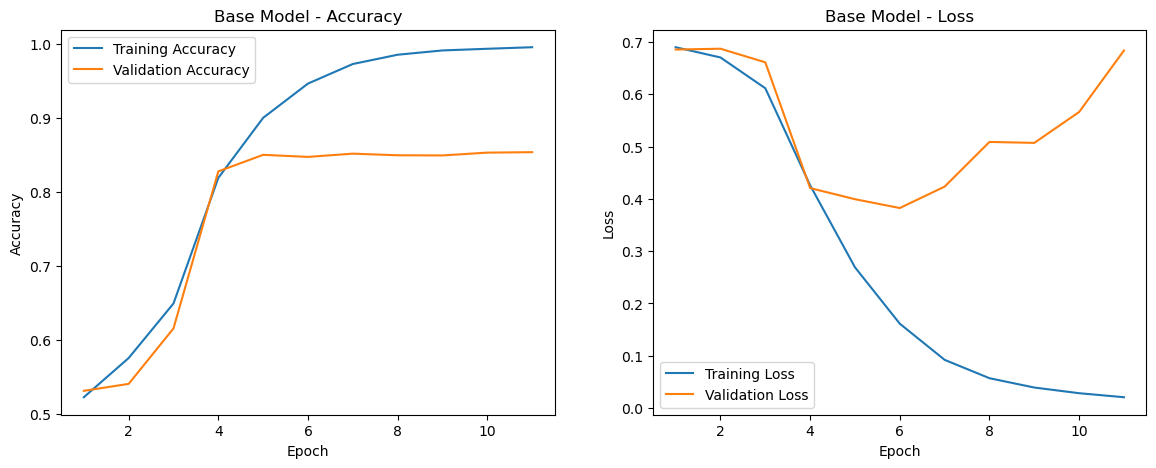

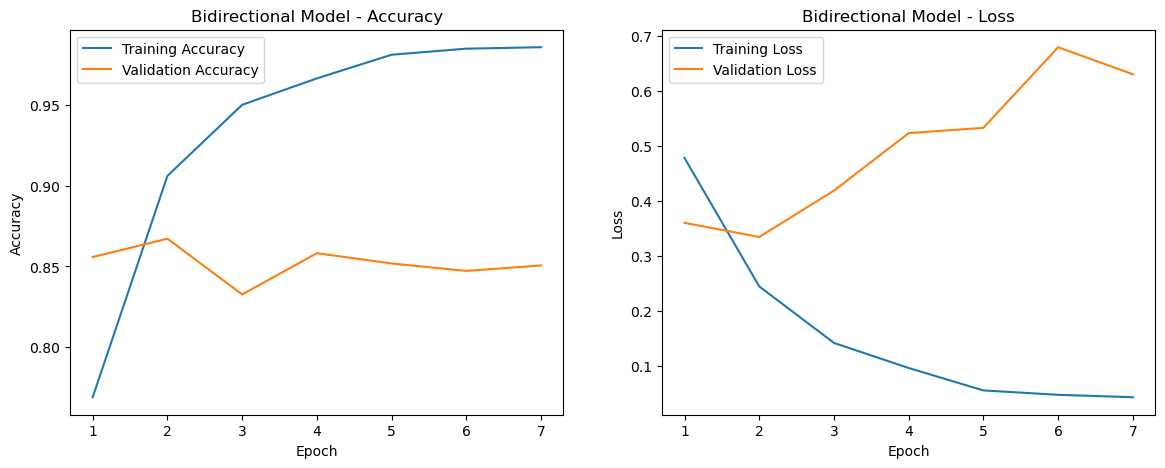

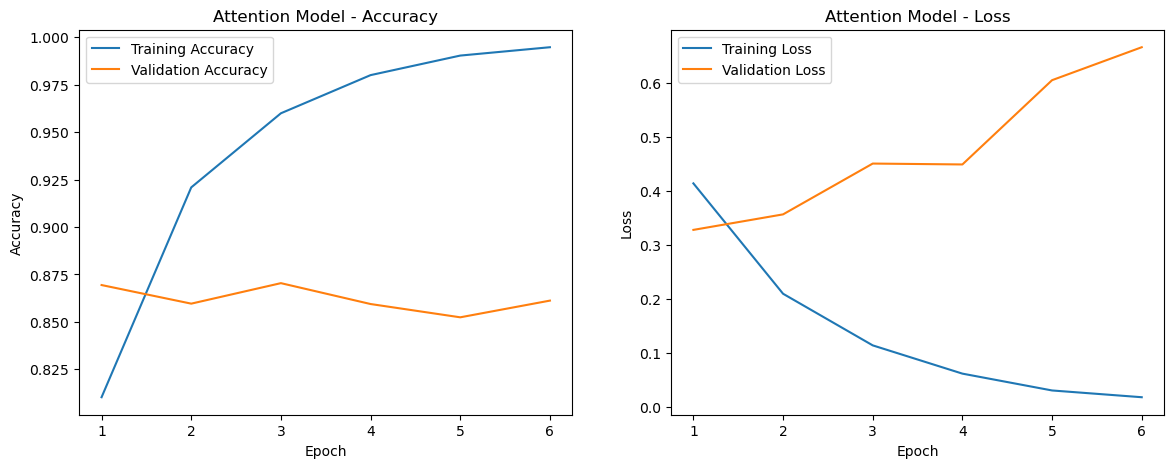

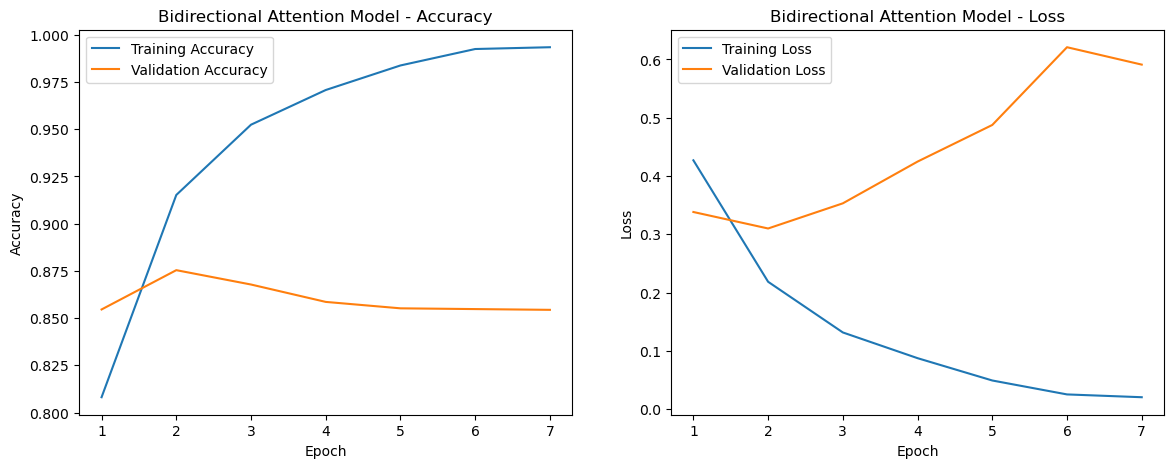

In [8]:
#plot histories of iterated model name
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
# plot histories
plot_history(base_history, "Base Model")
plot_history(bidirectional_history, "Bidirectional Model")
plot_history(attention_history, "Attention Model")
plot_history(bidirectional_attention_history, "Bidirectional Attention Model")


In [9]:
# here we want to compile and evalute the models given from the test data
def evaluate_model(model, x_test, y_test, model_name):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"{model_name} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return loss, accuracy

print("\nEvaluating Models on Test Data:")
base_loss, base_acc = evaluate_model(base_model, x_test_padded, y_test, "Base Model")
bidirectional_loss, bidirectional_acc = evaluate_model(bidirectional_model, x_test_padded, y_test, "Bidirectional Model")
attention_loss, attention_acc = evaluate_model(attention_model, x_test_padded, y_test, "Attention Model")
bidirectional_attention_loss, bidirectional_attention_acc = evaluate_model(bidirectional_attention_model, x_test_padded, y_test, "Bidirectional Attention Model")



Evaluating Models on Test Data:
Base Model - Test Loss: 0.4397, Test Accuracy: 0.8276
Bidirectional Model - Test Loss: 0.4019, Test Accuracy: 0.8328
Attention Model - Test Loss: 0.3543, Test Accuracy: 0.8479
Bidirectional Attention Model - Test Loss: 0.3665, Test Accuracy: 0.8464


In [10]:
import pandas as pd
#create table of results
data = {
    'Model': [
        'Base Model',
        'Bidirectional Model',
        'Attention Model',
        'Bidirectional Attention Model'
    ],
    'Test Loss': [
        base_loss,
        bidirectional_loss,
        attention_loss,
        bidirectional_attention_loss
    ],
    'Test Accuracy': [
        base_acc,
        bidirectional_acc,
        attention_acc,
        bidirectional_attention_acc
    ]
}

results_df = pd.DataFrame(data)
print("\nPerformance Summary:")
print(results_df)



Performance Summary:
                           Model  Test Loss  Test Accuracy
0                     Base Model   0.439731        0.82760
1            Bidirectional Model   0.401915        0.83276
2                Attention Model   0.354267        0.84788
3  Bidirectional Attention Model   0.366520        0.84640
